<a href="https://colab.research.google.com/github/Eddy-Emmanuel/AI_INDIAN_LICENSE_PLATE_RECOGNITION_DATA/blob/main/AI_INDIAN_LICENSE_PLATE_RECOGNITION_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ai-indian-license-plate-recognition-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F827967%2F1414839%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T083710Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D423f3038d0f71172951febc1e0b3f2b9c72a517bd04875a716fe2ce3f347f3facd67ad20a4a7cefc297d59f7aa2ff19ee18bc56c8d7b9ffedc35dbeaf72d78a652e24acf20df0c8e2c89121672185d5cbe12ec885c95d17de08685d5a93142c2e973b0ac10ce30ac313ea48949a5afbb10951f22ce36670f8c4ecdb84a9cf4155c5cb3d5af501a11afbe82522d4abcd1332adba73202a747d1379cc244c2b2aee29ebc9a90543a1c12c4307c7bbcf2b069d1435753b991309abba877f042324fb512024b82079c730a4420b57dd6ed46556d2862176c23427bfd474a4713aa4a8c9207fec7e5bbade27335754795c501122ece1dfe1a3048f6e79d5ef203abee'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1573971 bytes downloaded
Downloaded and uncompressed: ai-indian-license-plate-recognition-data
Data source import complete.


In [ ]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import glob as glb
import numpy as np
import pandas as pd

import cv2

import torch

from fastai.vision.all import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Input, Model, optimizers, callbacks, Sequential

In [ ]:
def LoadDf(split_type):
    data_path = glb.glob(f"/kaggle/input/ai-indian-license-plate-recognition-data/data/data/{split_type}/*/*.jpg")
    label = [i.split("/")[-2] for i in data_path]

    return pd.DataFrame({
        "image_path":data_path,
        "label":label
    })

In [ ]:
train_df = LoadDf("train")

val_df = LoadDf("val")

In [ ]:
train_df

,image_path,label
0,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_G/class_G_10.jpg,class_G
1,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_G/class_G_22.jpg,class_G
2,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_G/class_G_14.jpg,class_G
3,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_G/class_G_3.jpg,class_G
4,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_G/class_G_6.jpg,class_G
...,...,...
859,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_0/class_0_5.jpg,class_0
860,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_0/class_0_4.jpg,class_0
861,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_0/class_0_29.jpg,class_0
862,/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train/class_0/class_0_6.jpg,class_0


In [ ]:
print(train_df.shape, test_df.shape)

(864, 2) (216, 2)


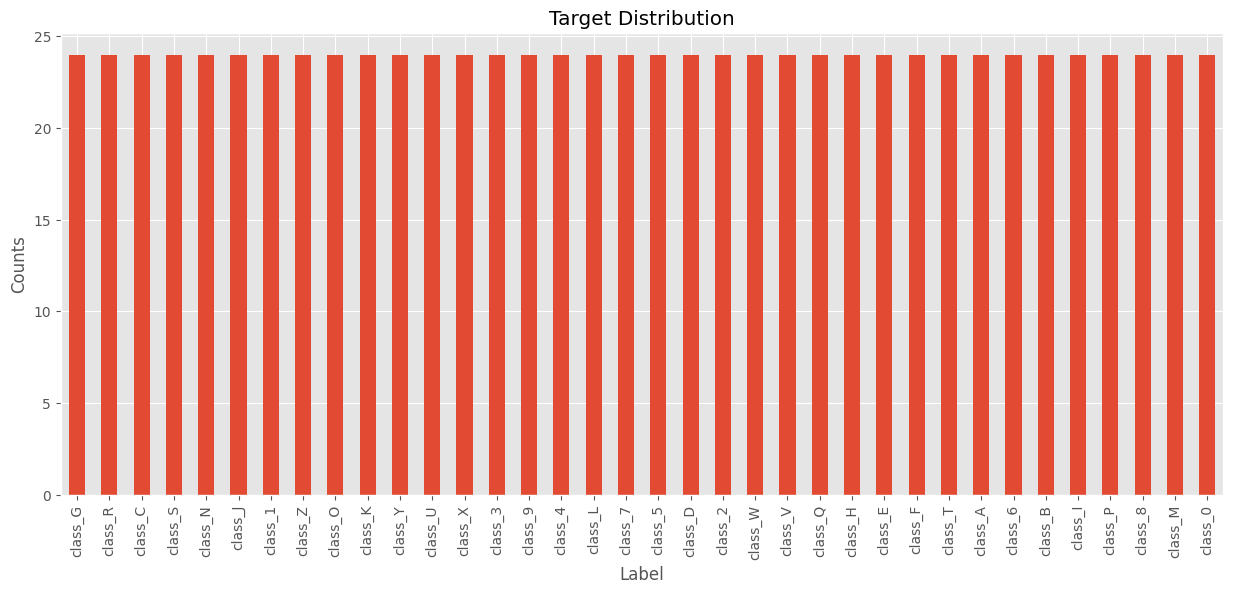

In [ ]:
train_df["label"].value_counts().plot(kind="bar",
                                      title="Target Distribution",
                                      figsize=(15, 6),
                                      xlabel="Label",
                                      ylabel="Counts")

plt.show()

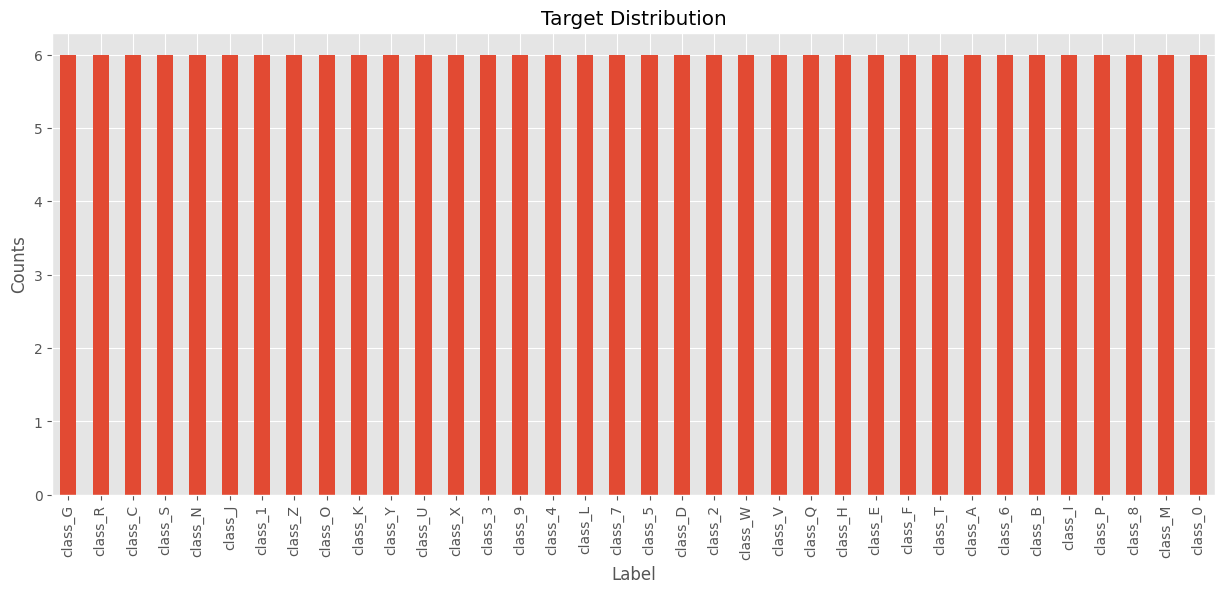

In [ ]:
val_df["label"].value_counts().plot(kind="bar",
                                    title="Target Distribution",
                                    figsize=(15, 6),
                                    xlabel="Label",
                                    ylabel="Counts")

plt.show()

## Load data for Tensorflow

In [ ]:
train_gen = ImageDataGenerator(horizontal_flip=True)
val_gen = ImageDataGenerator()

In [ ]:
train_dataloader = train_gen.flow_from_dataframe(dataframe=train_df,
                                                 x_col="image_path",
                                                 y_col="label",
                                                 target_size=(48, 48))

val_dataloader = val_gen.flow_from_dataframe(dataframe=val_df,
                                             x_col="image_path",
                                             y_col="label",
                                             target_size=(48, 48))

Found 864 validated image filenames belonging to 36 classes.
Found 216 validated image filenames belonging to 36 classes.


In [ ]:
batch_x, batch_y = next(train_dataloader)

print(batch_x.shape, batch_y.shape)

(32, 48, 48, 3) (32, 36)


## Modelling

In [ ]:
input_layer = Input(shape=batch_x.shape[1:])
# Convolutional layers
conv1 = layers.Conv2D(16, (22, 22), activation='relu', padding='same')(input_layer)
conv2 = layers.Conv2D(32, (16, 16), activation='relu', padding='same')(conv1)
conv3 = layers.Conv2D(64, (8, 8), activation='relu', padding='same')(conv2)
conv4 = layers.Conv2D(64, (4, 4), activation='relu', padding='same')(conv3)
# Max pooling layer
pooling = layers.MaxPooling2D(pool_size=(4, 4))(conv4)
# Dropout layer
dropout = layers.Dropout(0.4)(pooling)
# Flatten layer
flatten = layers.Flatten()(dropout)
# Fully connected layers
dense1 = layers.Dense(128, activation='relu')(flatten)
output_layer = layers.Dense(36, activation='softmax')(dense1)
# Define the model
license_model = Model(inputs=input_layer, outputs=output_layer)

license_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 16)        23248     
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        131104    
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        131136    
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                           

In [ ]:
license_model.compile(optimizer=optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
license_model_history = license_model.fit(train_dataloader,
                                          validation_data=test_dataloader,
                                          epochs=50,
                                          batch_size=32,
                                          callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=5),
                                                     callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)])

Epoch 1/50
27/27 [==============================] - 5s 48ms/step - loss: 7.6045 - accuracy: 0.0405 - val_loss: 3.5635 - val_accuracy: 0.0648 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 1s 28ms/step - loss: 3.2672 - accuracy: 0.1215 - val_loss: 2.7467 - val_accuracy: 0.2176 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 1s 27ms/step - loss: 2.4370 - accuracy: 0.3368 - val_loss: 1.3925 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 1s 29ms/step - loss: 1.3090 - accuracy: 0.6296 - val_loss: 0.6916 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 1s 27ms/step - loss: 0.8462 - accuracy: 0.7292 - val_loss: 0.7299 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 1s 29ms/step - loss: 0.5973 - accuracy: 0.8067 - val_loss: 0.5233 - val_accuracy: 0.8241 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 1s 29ms/step - loss: 0.4

In [ ]:
result = pd.DataFrame(license_model_history.history)

result

,loss,accuracy,val_loss,val_accuracy,lr
0,7.604454,0.040509,3.563547,0.064815,0.001000
1,3.267193,0.121528,2.746747,0.217593,0.001000
2,2.436977,0.336806,1.392490,0.611111,0.001000
3,1.308987,0.629630,0.691624,0.759259,0.001000
4,0.846249,0.729167,0.729902,0.759259,0.001000
5,0.597344,0.806713,0.523303,0.824074,0.001000
6,0.429443,0.876157,0.201837,0.953704,0.001000
7,0.308606,0.898148,0.240050,0.935185,0.001000
8,0.343112,0.901620,0.264003,0.916667,0.001000
9,0.204941,0.944444,0.219403,0.939815,0.000100


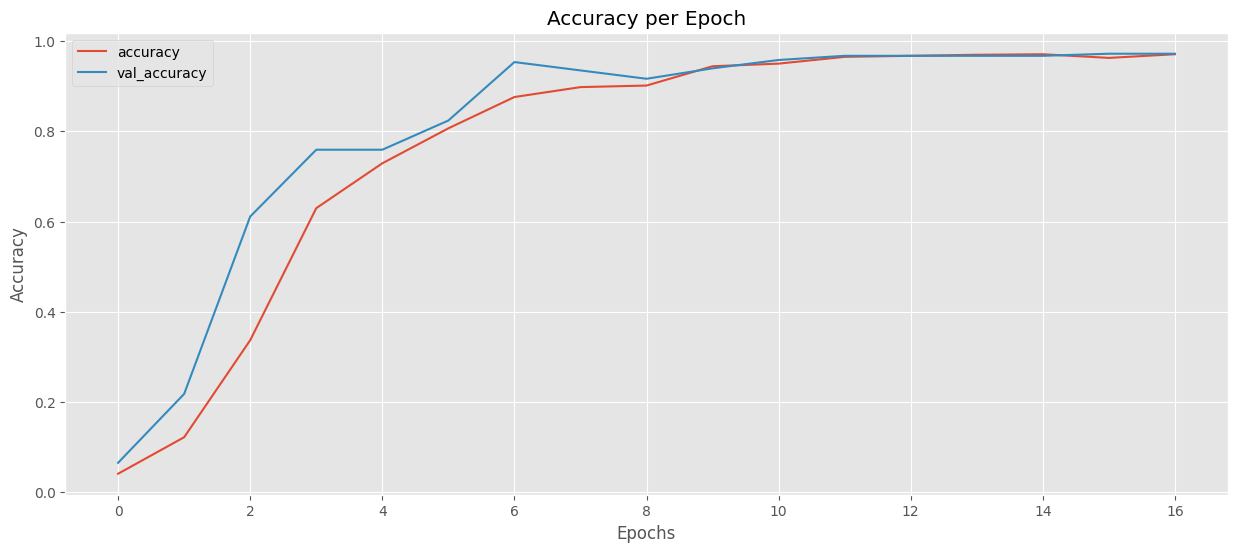

In [ ]:
result[["accuracy", "val_accuracy"]].plot(figsize=(15, 6),
                                          title="Accuracy per Epoch",
                                          xlabel="Epochs",
                                          ylabel="Accuracy")

plt.show()

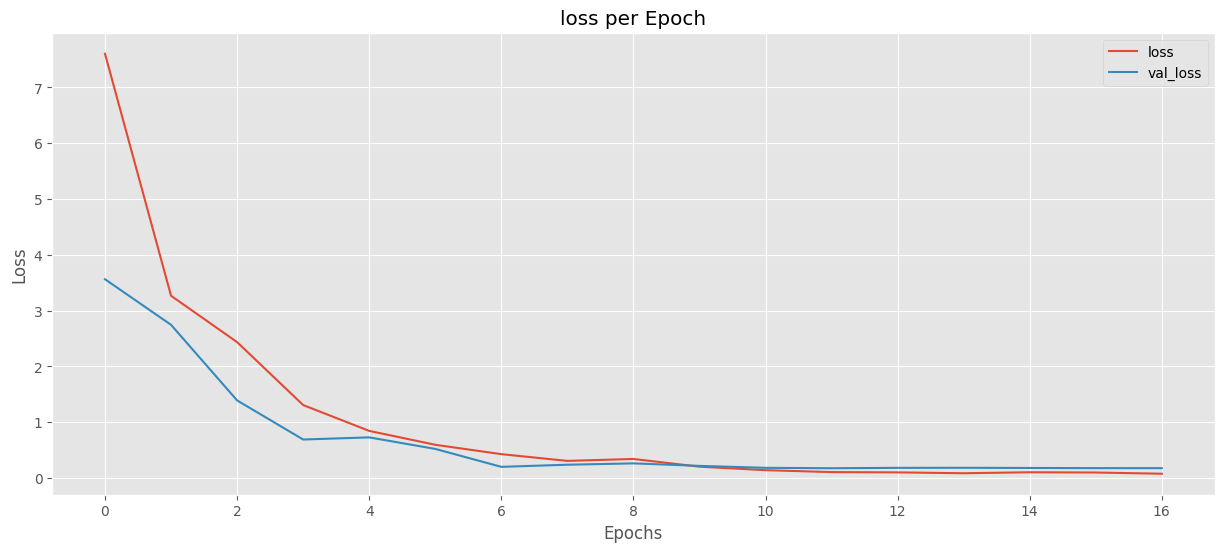

In [ ]:
result[["loss", "val_loss"]].plot(figsize=(15, 6),
                                          title="loss per Epoch",
                                          xlabel="Epochs",
                                          ylabel="Loss")

plt.show()

## Load data For Fastai

In [ ]:
path_id = "/kaggle/input/ai-indian-license-plate-recognition-data/data/data/train"

In [ ]:
fastai_imageloader = ImageDataLoaders.from_df(df=train_df,
                                              path="/",
                                              x_col = "image_path",
                                              y_col = "label",
                                              item_tfms=Resize(224),
                                              batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()])

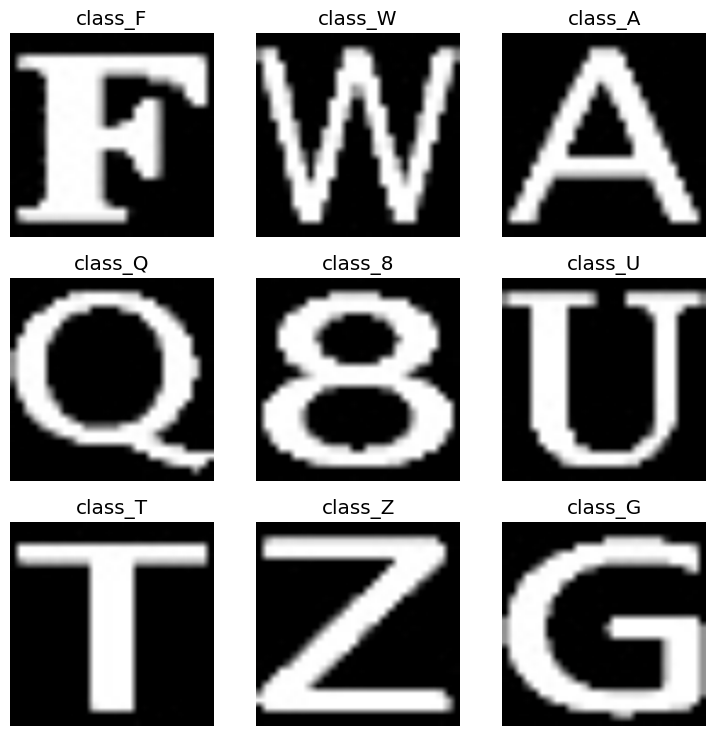

In [ ]:
fastai_imageloader.train.show_batch()

In [ ]:
v_learner = vision_learner(dls=fastai_imageloader,
                           arch=vgg16,
                           metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.5MB/s]


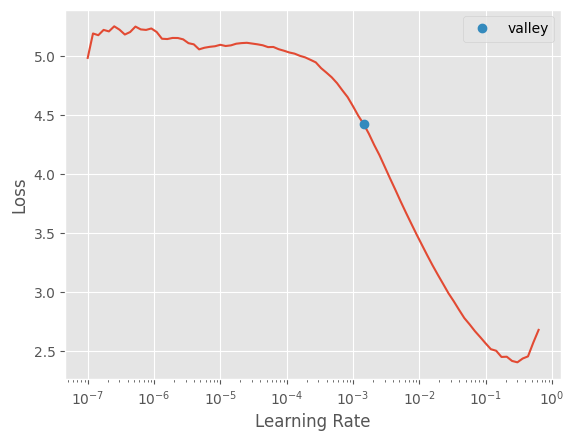

In [ ]:
best_lr = v_learner.lr_find()[0]

In [ ]:
v_learner.fine_tune(epochs=50, base_lr=best_lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.367131,2.404640,0.377907,0.622093,00:04


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.149106,1.898967,0.569767,0.430233,00:09
1,1.915819,1.473572,0.709302,0.290698,00:10
2,1.682261,1.104138,0.744186,0.255814,00:09
3,1.467183,0.819996,0.802326,0.197674,00:09
4,1.283660,0.612613,0.854651,0.145349,00:09
5,1.091780,0.474983,0.895349,0.104651,00:09
6,0.944716,0.392790,0.901163,0.098837,00:10
7,0.800566,0.331465,0.912791,0.087209,00:09
8,0.676912,0.279680,0.936047,0.063953,00:09
9,0.567653,0.254545,0.924419,0.075581,00:09


In [ ]:
interpreter = ClassificationInterpretation.from_learner(v_learner)

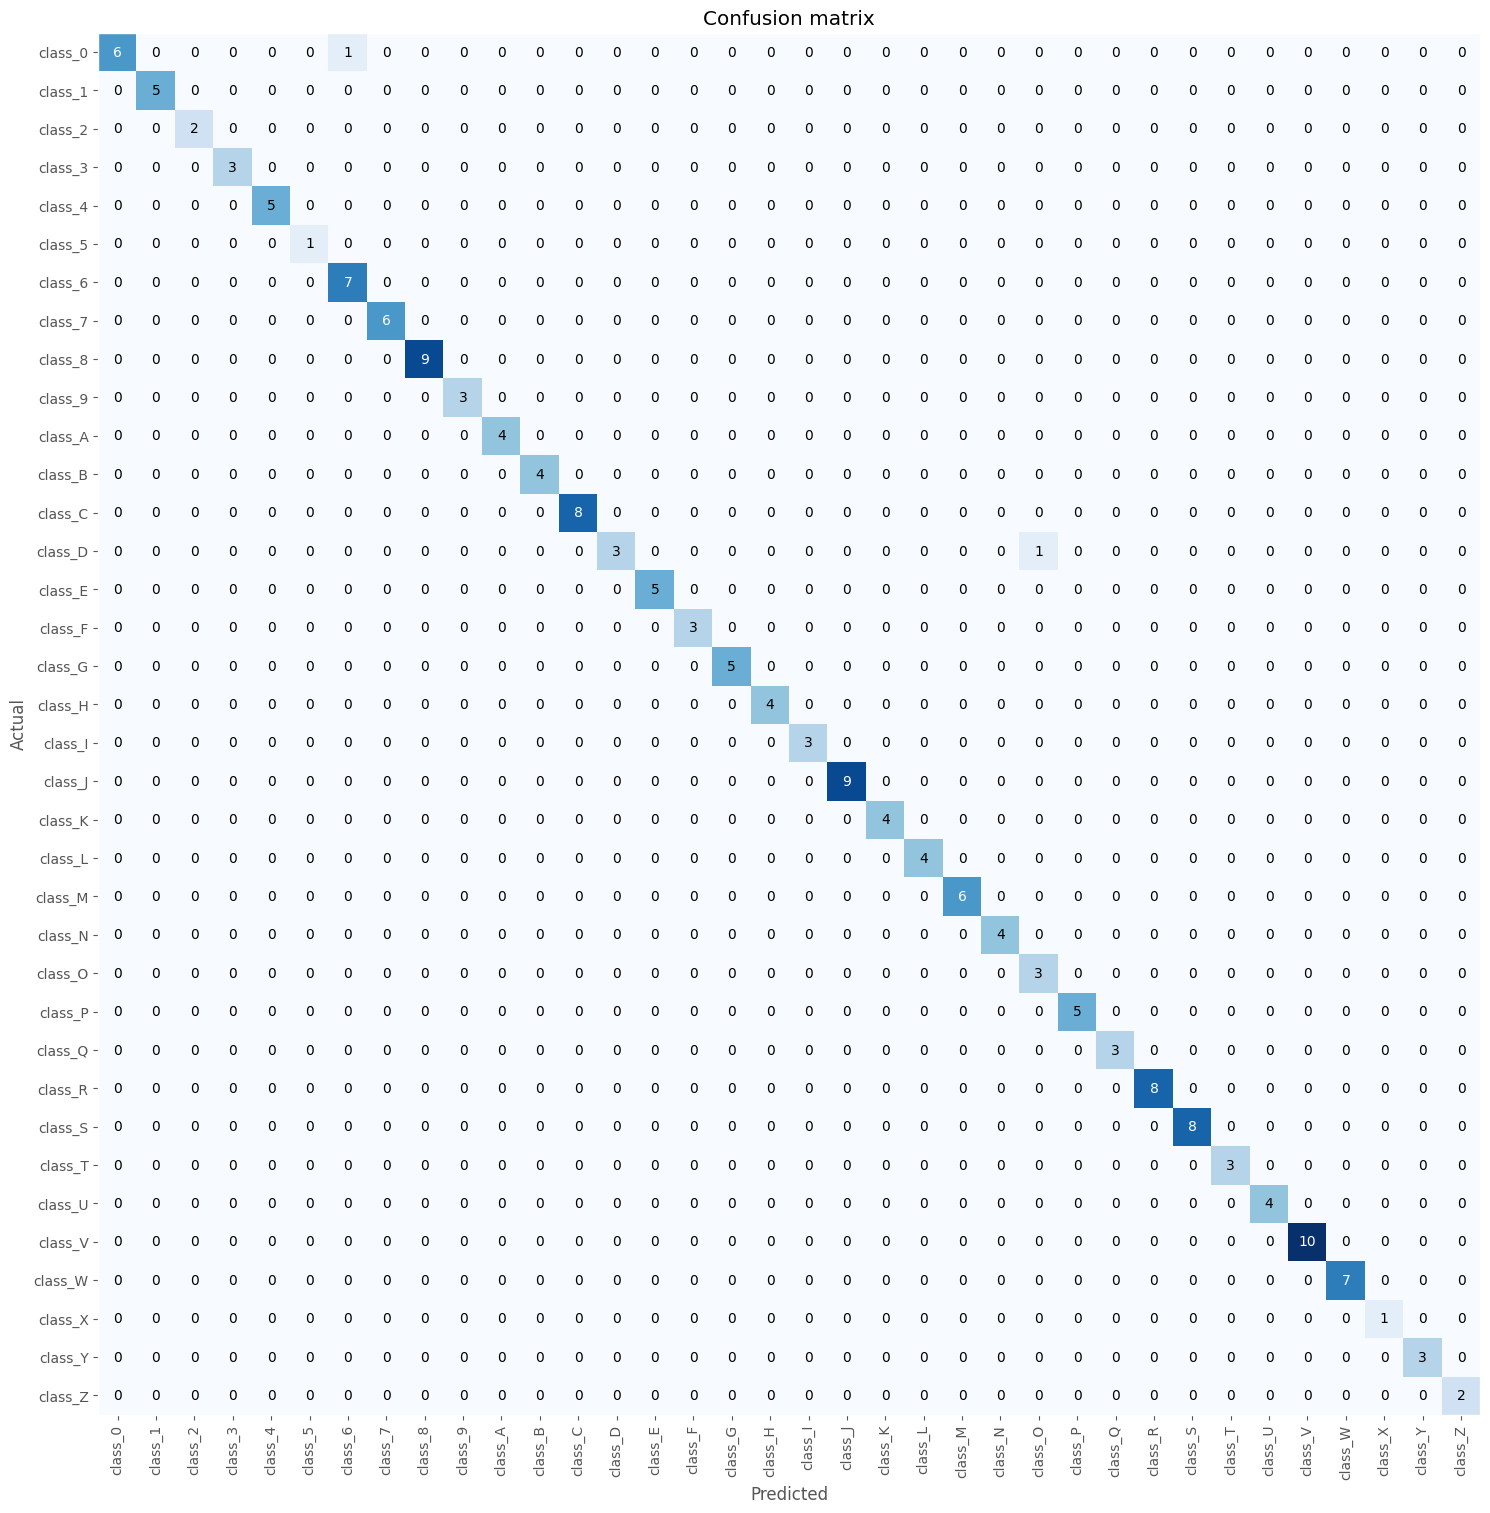

In [ ]:
interpreter.plot_confusion_matrix(figsize=(15, 15))

In [ ]:
interpreter.print_classification_report()

              precision    recall  f1-score   support

     class_0       1.00      0.86      0.92         7
     class_1       1.00      1.00      1.00         5
     class_2       1.00      1.00      1.00         2
     class_3       1.00      1.00      1.00         3
     class_4       1.00      1.00      1.00         5
     class_5       1.00      1.00      1.00         1
     class_6       0.88      1.00      0.93         7
     class_7       1.00      1.00      1.00         6
     class_8       1.00      1.00      1.00         9
     class_9       1.00      1.00      1.00         3
     class_A       1.00      1.00      1.00         4
     class_B       1.00      1.00      1.00         4
     class_C       1.00      1.00      1.00         8
     class_D       1.00      0.75      0.86         4
     class_E       1.00      1.00      1.00         5
     class_F       1.00      1.00      1.00         3
     class_G       1.00      1.00      1.00         5
     class_H       1.00    

In [ ]:
fastai_valdl = v_learner.dls.test_dl(val_df)

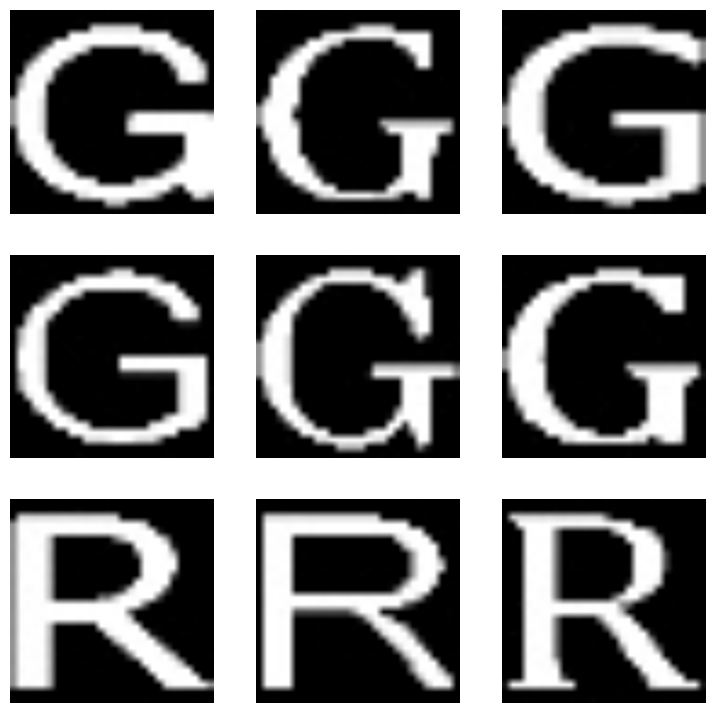

In [ ]:
fastai_testdl.show_batch()

In [ ]:
fastai_pred, _ = v_learner.get_preds(dl=fastai_valdl)

In [ ]:
val_img_path = val_df["image_path"][:9].values
preds = [v_learner.dls.vocab[i] for i in np.argmax(fastai_pred, axis=1)][:9]

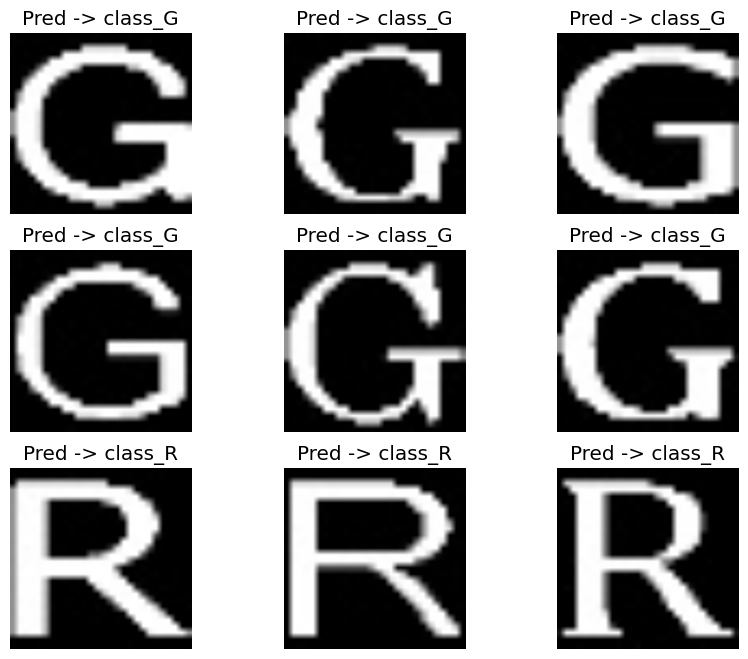

In [ ]:
plt.figure(figsize=(10, 8))
for idx, (img_path, pred) in enumerate(zip(val_img_path, preds), start=1):
    plt.subplot(3, 3, idx)
    plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (500, 500)))
    plt.title(f"Pred -> {pred}")
    plt.axis("off")

plt.show()

In [ ]:
v_learner.export("/content/v_learn.pkl")

In [ ]:
plate_cascade = cv2.CascadeClassifier('../input/ai-indian-license-plate-recognition-data/indian_license_plate.xml')

In [ ]:
def detect_plate(image, text=''):
    plate_image = image.copy()
    region_of_interest = image.copy()
    plate_rectangles = plate_cascade.detectMultiScale(plate_image, scaleFactor=1.2, minNeighbors=7)
    for (x, y, w, h) in plate_rectangles:
        roi = region_of_interest[y:y+h, x:x+w, :]
        plate = region_of_interest[y:y+h, x:x+w, :]
        cv2.rectangle(plate_image, (x+2, y), (x+w-3, y+h-5), (51, 181, 155), 3)
    if text != '':
        plate_image = cv2.putText(plate_image, text, (x-w//2, y-h//2),
                                   cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)

    return plate_image, plate

In [ ]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

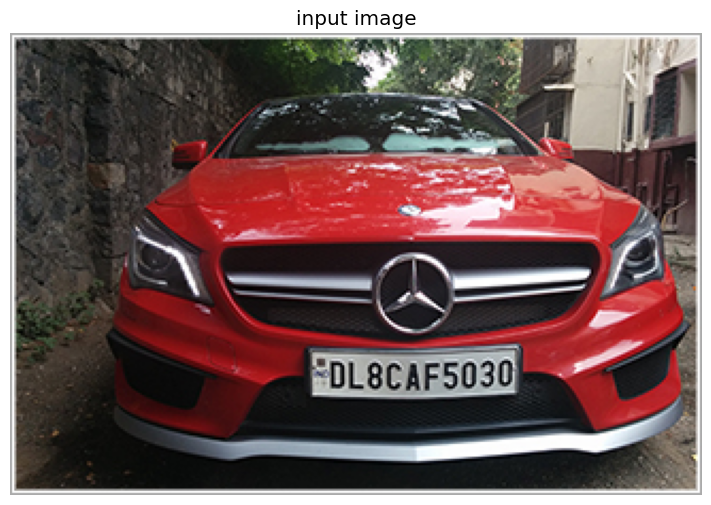

In [ ]:
img = cv2.imread('../input/ai-indian-license-plate-recognition-data/car.jpg')
display(img, 'input image')

In [ ]:
output_img, plate = detect_plate(img)

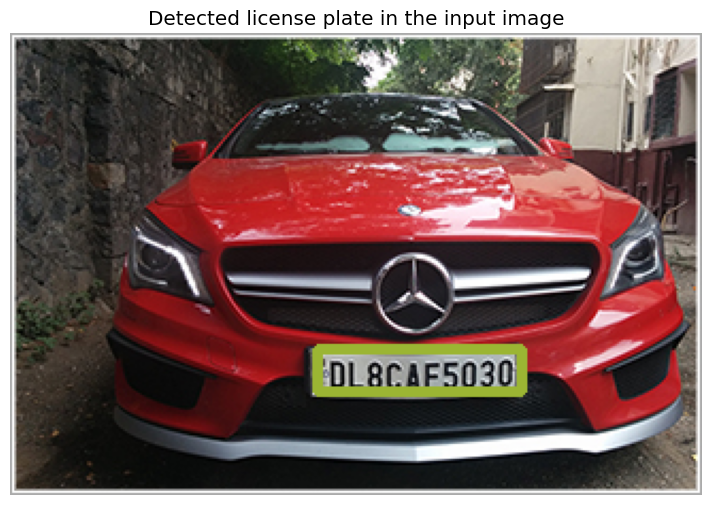

In [ ]:
display(output_img, 'Detected license plate in the input image')

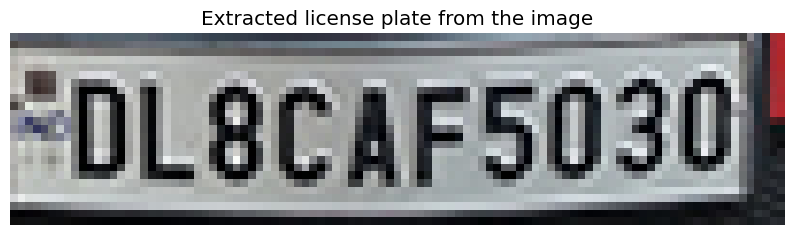

In [ ]:
display(plate, 'Extracted license plate from the image')

In [ ]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

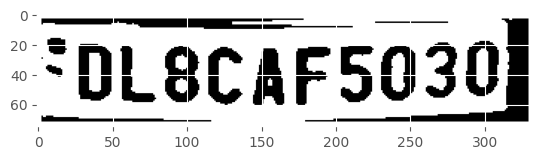

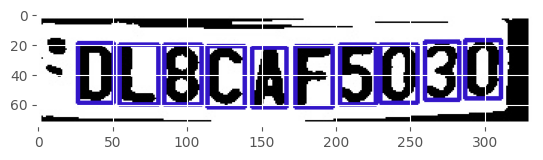

In [ ]:
char = segment_characters(plate)

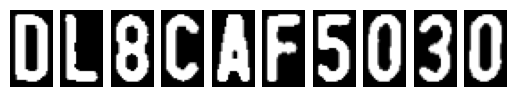

In [ ]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [ ]:
def fix_dimension(img):
    new_img = np.zeros((224,224,3), dtype=np.uint8)
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def crop_object(image, padding=10):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Find the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Expand the bounding box with padding
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] - x, w + 2 * padding)
    h = min(image.shape[0] - y, h + 2 * padding)

    # Crop the image using the adjusted bounding box
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

def show_results_v(learner):
    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (224,224))
        img = fix_dimension(img_)
        img = crop_object(img, 15)
        predictions = learner.predict(img)[0].split("_")[-1]
        output.append(predictions) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number

print(show_results_v(v_learner))

D1LY0LS03B


In [ ]:
fastai_imageloader = ImageDataLoaders.from_df(df=train_df,
                                              path="/",
                                              x_col = "image_path",
                                              y_col = "label",
                                              item_tfms=Resize(48))

In [ ]:
v_learner = vision_learner(dls=fastai_imageloader,
                           arch=vgg19,
                           metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 71.1MB/s]


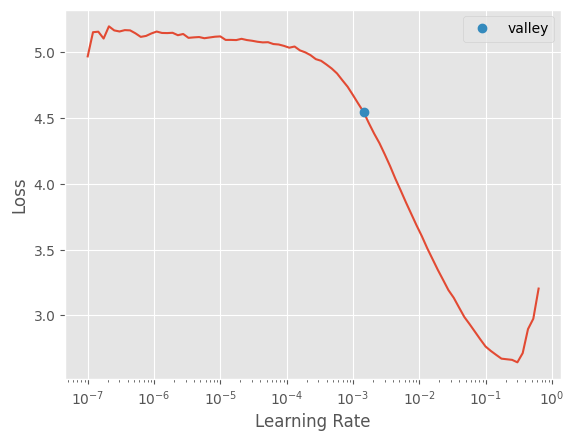

In [ ]:
best_lr = v_learner.lr_find()[0]

In [ ]:
v_learner.fine_tune(epochs=50, base_lr=best_lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.367003,2.302397,0.441860,0.558140,00:01


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.547166,1.917799,0.593023,0.406977,00:01
1,2.340527,1.601714,0.627907,0.372093,00:02
2,2.150705,1.322433,0.738372,0.261628,00:01
3,1.912389,1.111431,0.773256,0.226744,00:01
4,1.706782,0.905638,0.819767,0.180233,00:01
5,1.518780,0.734739,0.837209,0.162791,00:01
6,1.346310,0.605866,0.872093,0.127907,00:01
7,1.191377,0.486750,0.889535,0.110465,00:01
8,1.044843,0.419190,0.889535,0.110465,00:02
9,0.911007,0.353238,0.924419,0.075581,00:01


In [ ]:
interpreter = ClassificationInterpretation.from_learner(v_learner)

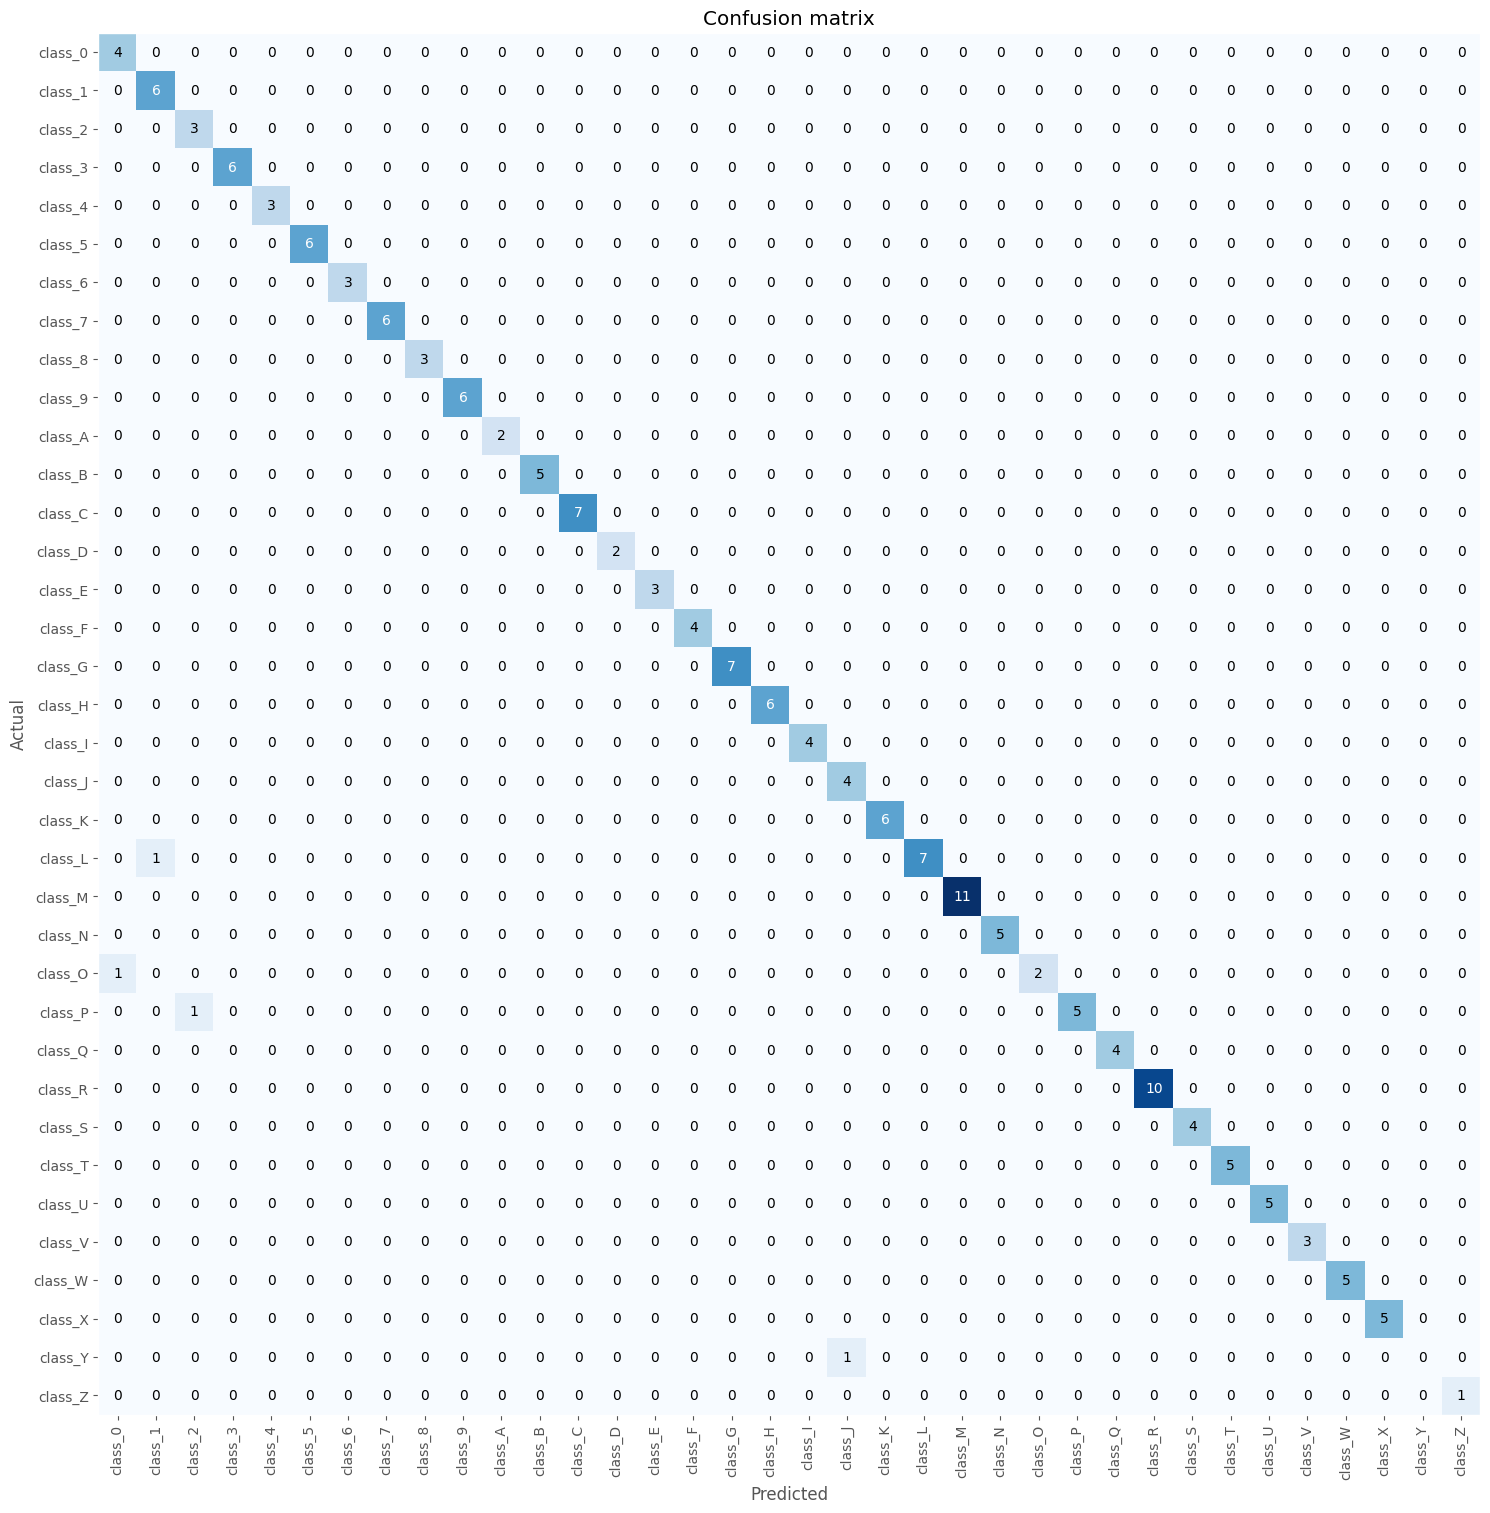

In [ ]:
interpreter.plot_confusion_matrix(figsize=(15, 15))

In [ ]:
interpreter.print_classification_report()

              precision    recall  f1-score   support

     class_0       0.80      1.00      0.89         4
     class_1       0.86      1.00      0.92         6
     class_2       0.75      1.00      0.86         3
     class_3       1.00      1.00      1.00         6
     class_4       1.00      1.00      1.00         3
     class_5       1.00      1.00      1.00         6
     class_6       1.00      1.00      1.00         3
     class_7       1.00      1.00      1.00         6
     class_8       1.00      1.00      1.00         3
     class_9       1.00      1.00      1.00         6
     class_A       1.00      1.00      1.00         2
     class_B       1.00      1.00      1.00         5
     class_C       1.00      1.00      1.00         7
     class_D       1.00      1.00      1.00         2
     class_E       1.00      1.00      1.00         3
     class_F       1.00      1.00      1.00         4
     class_G       1.00      1.00      1.00         7
     class_H       1.00    

In [ ]:
fastai_valdl = v_learner.dls.test_dl(val_df)

In [ ]:
fastai_pred, _ = v_learner.get_preds(dl=fastai_valdl)

In [ ]:
val_img_path = val_df["image_path"][:9].values
preds = [v_learner.dls.vocab[i] for i in np.argmax(fastai_pred, axis=1)][:9]

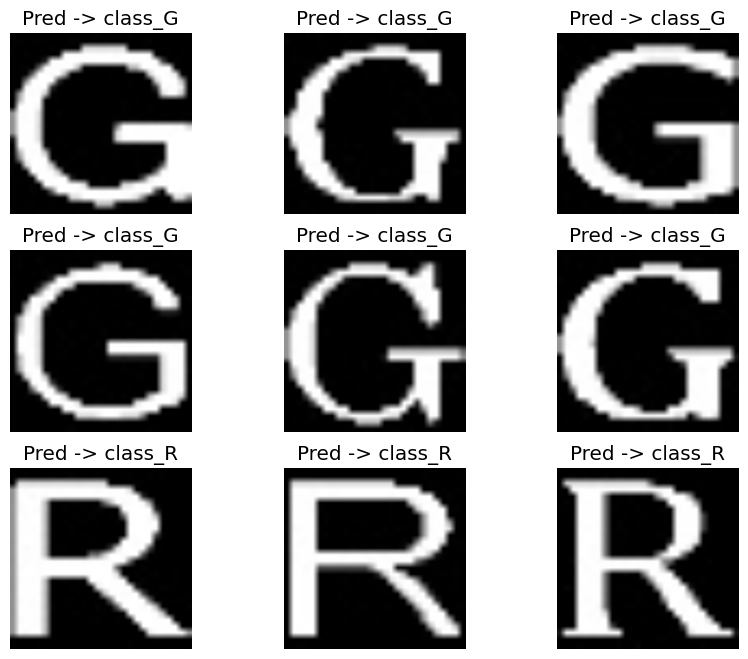

In [ ]:
plt.figure(figsize=(10, 8))
for idx, (img_path, pred) in enumerate(zip(val_img_path, preds), start=1):
    plt.subplot(3, 3, idx)
    plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (500, 500)))
    plt.title(f"Pred -> {pred}")
    plt.axis("off")

plt.show()

In [ ]:
show_results(v_learner)

'UI83NL3B3B'

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score

def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

model = Sequential()
model.add(layers.Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [ ]:
train_dataloader = train_gen.flow_from_dataframe(dataframe=train_df,
                                                 x_col="image_path",
                                                 y_col="label",
                                                 batch_size=1,
                                                 class_mode='sparse',
                                                 target_size=(28, 28))

val_dataloader = val_gen.flow_from_dataframe(dataframe=val_df,
                                             x_col="image_path",
                                             y_col="label",
                                             batch_size=1,
                                             class_mode='sparse',
                                             target_size=(28, 28))

Found 864 validated image filenames belonging to 36 classes.
Found 216 validated image filenames belonging to 36 classes.


In [ ]:
batch_size = 1
history = model.fit_generator(train_dataloader,
                              steps_per_epoch=train_dataloader.samples // batch_size,
                              validation_data=val_dataloader,
                              epochs=100,
                              verbose=1,
                              callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=5),
                                         callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)])

Epoch 1/80
864/864 [==============================] - 14s 9ms/step - loss: 4.2788 - custom_f1score: 0.1273 - val_loss: 2.4766 - val_custom_f1score: 0.3935 - lr: 1.0000e-04
Epoch 2/80
864/864 [==============================] - 8s 9ms/step - loss: 1.9963 - custom_f1score: 0.4514 - val_loss: 1.0184 - val_custom_f1score: 0.7130 - lr: 1.0000e-04
Epoch 3/80
864/864 [==============================] - 10s 12ms/step - loss: 1.2466 - custom_f1score: 0.6400 - val_loss: 0.6761 - val_custom_f1score: 0.8009 - lr: 1.0000e-04
Epoch 4/80
864/864 [==============================] - 7s 8ms/step - loss: 0.7456 - custom_f1score: 0.7743 - val_loss: 0.3441 - val_custom_f1score: 0.8981 - lr: 1.0000e-04
Epoch 5/80
864/864 [==============================] - 8s 9ms/step - loss: 0.7242 - custom_f1score: 0.7986 - val_loss: 0.3032 - val_custom_f1score: 0.8889 - lr: 1.0000e-04
Epoch 6/80
864/864 [==============================] - 8s 9ms/step - loss: 0.5420 - custom_f1score: 0.8356 - val_loss: 0.3351 - val_custom_f1sc

In [ ]:
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results(model):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(model.predict(img)[0]) #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number

In [ ]:
show_results(model)

1/1 [==============================] - 0s 29ms/step


'0L9CAF5030'

In [ ]:
train_gen = ImageDataGenerator(horizontal_flip=True, rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
val_gen = ImageDataGenerator()

In [ ]:
train_dataloader = train_gen.flow_from_dataframe(dataframe=train_df,
                                                 x_col="image_path",
                                                 y_col="label",
                                                 batch_size=1,
                                                 class_mode='sparse',
                                                 target_size=(28, 28))

val_dataloader = val_gen.flow_from_dataframe(dataframe=val_df,
                                              x_col="image_path",
                                              y_col="label",
                                              batch_size=1,
                                              class_mode='sparse',
                                              target_size=(28, 28))

Found 864 validated image filenames belonging to 36 classes.
Found 216 validated image filenames belonging to 36 classes.


In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score

def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

model = Sequential()
model.add(layers.Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        23248     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                      

In [ ]:
batch_size = 1
history = model.fit_generator(train_dataloader,
                              steps_per_epoch=train_dataloader.samples // batch_size,
                              validation_data=val_dataloader,
                              epochs=100,
                              verbose=1,
                              callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=5),
                                         callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)])

Epoch 1/100
864/864 [==============================] - 11s 10ms/step - loss: 3.2170 - custom_f1score: 0.1204 - val_loss: 115.6550 - val_custom_f1score: 0.4074 - lr: 1.0000e-04
Epoch 2/100
864/864 [==============================] - 7s 8ms/step - loss: 1.8671 - custom_f1score: 0.4178 - val_loss: 69.7878 - val_custom_f1score: 0.7037 - lr: 1.0000e-04
Epoch 3/100
864/864 [==============================] - 9s 10ms/step - loss: 1.2027 - custom_f1score: 0.5972 - val_loss: 79.8618 - val_custom_f1score: 0.7593 - lr: 1.0000e-04
Epoch 4/100
864/864 [==============================] - 9s 10ms/step - loss: 0.8356 - custom_f1score: 0.7141 - val_loss: 33.3281 - val_custom_f1score: 0.8657 - lr: 1.0000e-04
Epoch 5/100
864/864 [==============================] - 8s 10ms/step - loss: 0.6410 - custom_f1score: 0.7951 - val_loss: 45.4166 - val_custom_f1score: 0.9028 - lr: 1.0000e-04
Epoch 6/100
864/864 [==============================] - 14s 16ms/step - loss: 0.5447 - custom_f1score: 0.8171 - val_loss: 22.4957 

In [ ]:
show_results(model)

1/1 [==============================] - 0s 20ms/step


'DL8CAF5030'

1/1 [==============================] - 0s 20ms/step


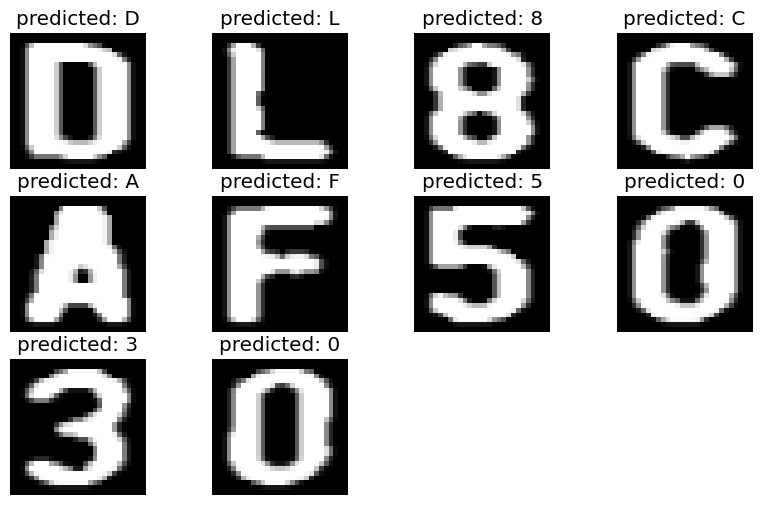

In [ ]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(model)[i]}')
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 20ms/step


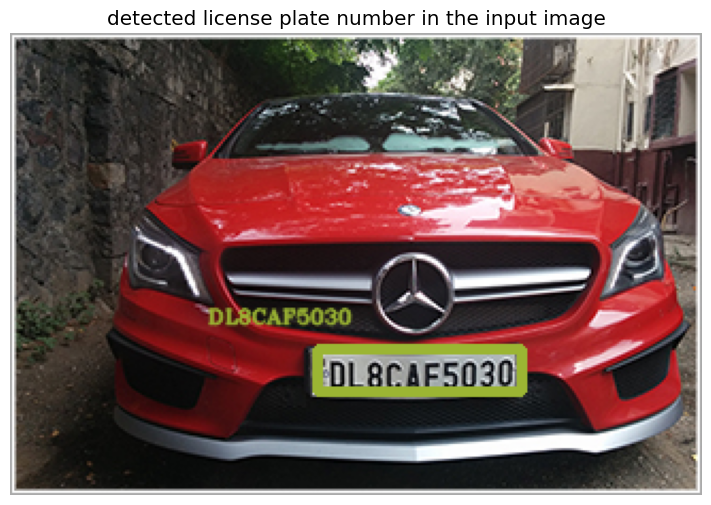

In [ ]:
plate_number = show_results(model)
output_img, plate = detect_plate(img, plate_number)
display(output_img, 'detected license plate number in the input image')

In [ ]:
model.save("license_model.h5")